<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://www.mathworks.com/help/examples/stats/win64/ParellelBayeianOptimizationExample_01.png" 
/>

</figure>


<h1 style="width: 60%; color: Orange; font-size: 40pt;">
    <Strong>
        CEGM2003 project: Bayesian optimization for truss structures
    </Strong>
</h1>

<h2 id="Background"><B>
    Background<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background"><B>
    Objective & Description<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>

<div style="width: 60%; border-top: 4px solid #34D058; border-left: 4px solid #34D058; background-color: #F6FFED; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #34D058; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective</strong></div>
    <p><strong>The aim of this project is to find an optimal truss design,</strong><br>
    this will be achieved by finding an optimal set of nodal coordinates and cross-sectional properties. The primary objective is to minimize the total weight of the structure, while satisfying structural requirements. Optionally, additional objectives can be included, e.g. on the minimization of cutoff waste when reusing components from an existing inventory of elements.</p>
</div>

## <strong> X | Imports</strong>

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import sys
import pandas as pd
import io
import os
import botorch
import plotly.express as px


from tabulate import tabulate
from contextlib import redirect_stdout
from sklearn.preprocessing import MinMaxScaler

from botorch.utils.transforms import normalize
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize
#from botorch.acquisition import EntropySearch 
from botorch.acquisition import ExpectedImprovement

sys.path.append('../pyJive/')
from utils import proputils as pu
from names import GlobNames as gn
import main

In [2]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## <strong> X | Classes & Dependencies</strong>

In [148]:
class TRUSS():
    def __init__(self, file_path, file_name, output_path, write_name, violation_penalty, scalers, bounds, lower_area=4e-3, freq_constraints=[20, 40, 60], mass_weight=1, freq_weight=1):
        # Configuration Parameters
        self.config = {
            "read_file_path": file_path,
            "read_file_name": file_name,
            "write_file_path": output_path,
            "write_file_name": write_name,
            "violation_penalty": violation_penalty,
            "scalers": {"y": scalers[0], "a": scalers[1]},
            "lower_area": lower_area,
            "bounds" : bounds,
            "freq_constraints": freq_constraints,
            "mass_weight": mass_weight,
            "freq_weight": freq_weight,
            "density": 7850,  # kg/m^3 As per Garnachos
        }

        self.state = {
            "nodes": {},
            "connectivity": None,
            "member_df": None,
            "y_coordinates": None,
            "x_coordinates": None,
            "cross_sections": None,
            "lengths": None,
            "min_mass": 700,
            "monitor_df": None
        }

        self.columns = ["Metric", "Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"]
        self.state["monitor_df"] = pd.DataFrame(columns=self.columns)
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], self.config["read_file_name"]))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
            elif line.startswith('member:'):
                section = 'member'
            else:
                if section == 'node' and line:
                    parts = line.split()
                    node_number = int(parts[0])
                    node_data = tuple(map(float, parts[1:]))
                    nodes[node_number] = node_data
                elif section == 'member' and line:
                    member_data = tuple(map(int, line.split()))
                    members.append(member_data)

        self.state["nodes"] = nodes
        self.state["member_df"] = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])

        connectivity = self.state["member_df"].to_numpy()
        self.state["connectivity"] = connectivity[:, :2]
        self.state["y_coordinates"] = np.array([value[1] for _, value in nodes.items()])
        self.state["x_coordinates"] = np.array([value[0] for _, value in nodes.items()])

    def get_write_geom_file(self,path_,write_file): 
        path = os.path.normpath(os.path.join(path_,write_file))
        file = open(path)

        for i, (x, _) in self.state["nodes"].items():
            self.state["nodes"][i] = (x, self.state["y_coordinates"][i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.state["nodes"].items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        connectivity = self.state["member_df"].to_numpy()
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        output_file_path = os.path.normpath(os.path.join(path_,'TRUSS.geom'))
        with open(output_file_path, 'w') as file:
            file.write(geom)
            
        return file.name
    
    def fit_scalers(self, initial_data):
        y_data = initial_data[:5].reshape(1, -1).T
        a_data = initial_data[5:].reshape(1, -1).T
        self.config["scalers"]["y"].fit(y_data)
        self.config["scalers"]["a"].fit(a_data)

    def scaler(self, mode, x_values, scaler_type):
        scaler = self.config["scalers"][scaler_type]
        x_values = x_values.reshape(1, -1).T
        if mode == 'scale':
            scaled_values = scaler.transform(x_values)
        elif mode == 'descale':
            scaled_values = scaler.inverse_transform(x_values)
        return scaled_values.flatten()
    
    def areas_coordinates_write_split(self, x_list):        
        y_coordinates = np.copy(self.state["y_coordinates"])  # Use a copy to avoid modifying the original array directly
        areas = x_list[5:]
        y_coords = x_list[:5]
        for i, y in enumerate(y_coords, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        self.state["y_coordinates"] = y_coordinates  # Update state

        return areas, y_coords
    # ---------------------------------------------------------------------------- #
    #                                TARGET FUNCTION                               #
    # ---------------------------------------------------------------------------- #
    def loss_function(self, x_list):
        """
        Calculate the loss for a given set of design parameters.
        Parameters:
        x_list (list): A list of design parameters.
        Returns:
        float: The calculated loss based on mass, frequency constraints, and imaginary penalties.
        """

        if isinstance(x_list,torch.Tensor):
            x_list = x_list.detach().cpu().numpy().flatten()
            self.temporary = x_list
        A_list, y_list = self.areas_coordinates_write_split(x_list)
        mass_truss = self.mass_truss(A_list, y_list)
        
        freq1, freq2, freq3 = self.eigenfrequencies(A_list)
        frequencies = [freq1, freq2, freq3]

        freq_penalty = 0
        for f, t in zip(frequencies, self.config["freq_constraints"]):
            diff = f - t
            penalty_factor = 1 if diff >= 0 else self.config["violation_penalty"]
            freq_penalty += penalty_factor * (np.abs(diff) / t)
                
        normalized_mass_penalty = (mass_truss - 350) / 350
        normalized_freq_penalty = freq_penalty / len(self.config["freq_constraints"])
        constraint_violation = normalized_freq_penalty + normalized_mass_penalty

        LOSS = (self.config["mass_weight"] * normalized_mass_penalty +
                self.config["freq_weight"] * normalized_freq_penalty)
        # -------------------------- Optimisation monitoring ------------------------- #
        optmonitor_data = [
            ["Metric","Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"],
            ["Value",LOSS, frequencies, mass_truss, normalized_mass_penalty, normalized_freq_penalty, constraint_violation]
        ]
        print(f'{tabulate(optmonitor_data, headers="firstrow", tablefmt="grid")}\n')
        
        row_data = optmonitor_data[1][0:]
        new_data = pd.DataFrame([row_data], columns=self.columns)
        self.state["monitor_df"] = pd.concat([self.state["monitor_df"], new_data], ignore_index=True)

        return LOSS

    # ----------------------------- SUPPORT FUNCTIONS ---------------------------- #
    def eigenfrequencies(self,A_list):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], 'bridge_frequency.pro'))
        
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.get_write_geom_file(self.config["write_file_path"], self.config["write_file_name"])
        
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return (globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.state["x_coordinates"]
        y_coordinates = self.state["y_coordinates"]
        
        for i, y in enumerate(y_list, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(len(self.state["connectivity"]))
        for i, (node1, node2) in enumerate(self.state["connectivity"]):
            x1, y1 = coordinates[node1]  # Adjusting index to start from 0
            x2, y2 = coordinates[node2]
            lengths[i] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        n_elements = self.state["member_df"].iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.state["member_df"].iloc[:,-1] 
        
        for i,item in enumerate(cross_section_number):
                areas_i[i] = areas[item]
        self.temporary = areas_i
        self.state["cross_sections"] = areas[:15]
        self.state["lengths"] = lengths

        volumes = lengths * areas_i
        total_volume = np.sum(volumes)
        dens = 7800
        mass = total_volume * dens

        return mass
    # ----------------------------------- OTHER ---------------------------------- #
    def Initial_guess(self, optim_dims):
        sampled_points = np.zeros(len(optim_dims))
        for i, dim_index in enumerate(optim_dims):
            lower_bound, upper_bound = bounds[i]
            sampled_points[i] = np.random.uniform(lower_bound, upper_bound)
        return sampled_points


In [46]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size, bounds):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.bounds = bounds
        self.boundsmm = [(0,1),(0,1)] # Bounds consistent with Minmax scaling 
        self.x_bounds = [self.boundsmm[0]] * 5 + [self.boundsmm[1]] * 15 
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        self.uncertainty = []
        self.y_loss = []
        
        matern_length_scale_bounds = (1e-3, 1e10)
        initial_length_scale = np.ones(20)
        kernel = ConstantKernel(1.0) * Matern(length_scale=initial_length_scale, length_scale_bounds=matern_length_scale_bounds, nu=0.5)

        self.gauss_pr =  GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_expected_improvement(self, x_new):
        '''
        Calculates the expected improvement at a given point x_new
        '''
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(x_new).reshape(1, -1), return_std=True)
        if sigma_y_new[0] == 0.0:
            return 0.0
        
        min_mean_y = self.y_min
        z = (min_mean_y - mean_y_new) / sigma_y_new        
        exp_imp = (min_mean_y - mean_y_new) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        return exp_imp
  
    def _get_next_probable_point(self):
        '''
        We only standardise the data after the minimisation so the LOSS FUNCTION operates with standard scales
        ### FIX , Before We were only returning if better this does not allow the gaussian process to understand the data as well
        '''
        x_optimal = None
        x_next_sc = None
        max_acq_value = float('inf')

        for _ in range(self.batch_size):
            x_start = self.next_guess()  # Random starting point for exploration 
            x_start_sc = self.scaler(x_start, 'scale')       

            res = minimize(fun=self._acquisition_function, x0=x_start_sc, bounds = self.x_bounds, method='L-BFGS-B')
            # --------------------------------- Normalise -------------------------------- #
            if res.fun < max_acq_value:
                max_acq_value = res.fun
                x_next_sc = res.x
                x_optimal = self.scaler(x_next_sc, 'descale')

        return x_optimal, x_next_sc, -max_acq_value  #Note: Negative min neg acq function
    
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  
    def optimize(self):
        '''
        Optimize the target function using the Gaussian Process Regressor.

        Returns:
        - optimal_x: The optimal input values that minimize the target function.
        - y_min: The minimum value of the target function.
        '''
        # Initialize the Gaussian Process Regressor with the best guess
        y_min_ind = np.argmin(self.y_init)
        y_min = self.y_min = self.y_init[y_min_ind] 
        optimal_x = self.x_init[y_min_ind]
        optimal_ei = None

        if isinstance(self.y_init, list):
            self.y_init = np.array(self.y_init)
        
        for i in range(self.n_iter):
            print(f'Iteration: {i} Best loss = {y_min:.2f}\n')
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next ,x_next_sc, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array(x_next)) ## Call loss Function
            self._extend_prior_with_posterior_data(x_next_sc,y_next)
            if ((y_next < y_min) & (y_next > 0)):
                y_min = self.y_min = y_next
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(norm(prev_x - x_next))
                prev_x = x_next

            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"x": [optimal_x],"y": [y_min], "ei": [optimal_ei]})), ignore_index=True) 
        return optimal_x, y_min

    def next_guess(self):
        y_bound = self.bounds[0]
        A_bound = self.bounds[1]
        y = np.random.uniform(y_bound[0], y_bound[1], 5)
        Areas = np.random.uniform(A_bound[0], A_bound[1], 15)
        x_list = np.append(y, Areas)
        return x_list
    
    def scaler(self, x, mode):
        y_coords = x[:5]
        y_coords_sc = SC_wrapper(mode, y_coords, 'y')
        areas = x[5:]
        areas_sc = SC_wrapper(mode, areas, 'a')
        x_out = np.concatenate([y_coords_sc, areas_sc])
        return x_out 

In [47]:
# ------------------------------ OTHER FUNCTIONS ----------------------------- #
def SC_wrapper(mode,x,scaler):
    return TRUSS1.scaler(mode,x, scaler)

def objective_function(x):
    return TRUSS1.loss_function(x)

def final_results(file_path, OBJECT, best_x, cross_sections):
    # Read the input file and store in props object
    areas ,y_coords = OBJECT.areas_coordinates_write_split(best_x)
    mass = OBJECT.mass_truss(areas, y_coords)
    OBJECT.get_write_geom_file(file_path, 'TRUSS.geom')

    path = os.path.normpath(os.path.join(file_path,'bridge_frequency_truss.pro'))
    props = pu.parse_file(path)
    props['model']['truss']['area'] = cross_sections
    props['init']['mesh']['file'] = OBJECT.get_write_geom_file(file_path,"TRUSS.geom" )

    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)

# <strong> Default</strong>

## <strong> 1 | Initialisation</strong>

In [236]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../truss_bridge/data'
read_file = 'bridge.geom'
write_file_path =  '../truss_bridge/data/@TRUSS'
write_file = 'TRUSS.geom'

optim_dims = [i for i in range(20)]  
lower_area = 40e-4
violation_factor = 10
freq_constraints = [20,40,60]
mass_weight = 2
freq_weight = 4
A_bound = (0.0001, 0.01)
y_bound = (0.5, 2)

scalers = [MinMaxScaler(),MinMaxScaler()] # [y_scaler, a_scaler]
AL_bound = (lower_area - A_bound[0], lower_area + A_bound[0])
bounds = np.array([y_bound if index <= 4 else A_bound for index in optim_dims])
bounds[5] = AL_bound

TRUSS1 = TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS1.read_geom_file()

# -------------------------------- Initiation -------------------------------- #
n_samples = 10 
x_list = []
y_list = []
x_list_sc = []
x_0 = np.empty(len(optim_dims))

for _ in range(n_samples):
    x_c = np.copy(x_0) # Reset seed
    x_random = TRUSS1.Initial_guess(optim_dims)
    x_c[optim_dims] = x_random
    x_list.append(x_c)
# 
trap = io.StringIO()
with redirect_stdout(trap):
    for x in x_list:
        LOSS = TRUSS1.loss_function(x)
        y_list.append(LOSS)

# ---------------------------- INITIATE OPTIMISER ---------------------------- #
bounds = torch.tensor(bounds.T)
X_init = torch.tensor(np.array(x_list))
X_init_norm = normalize(X_init, bounds=bounds)  
y_init_t = torch.tensor(y_list).reshape(-1,1)

C:\Users\javie\AppData\Local\Temp\ipykernel_26188\1003929258.py:157: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



## <strong> 2 | Optimisation </strong>

In [237]:
n_iter = 200
batch_size = 50
Nrestats = 10

y_init_opt , x_init_opt = y_init_t, X_init_norm 
gp_model = SingleTaskGP(X_init_norm, y_init_opt)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

for iteration in range(n_iter):
    print(f'Iteration: {iteration} Best loss = {Y_init.min().item():.2f}')
    acq_func = ExpectedImprovement(model=gp_model, best_f=Y_init.min(), maximize=False)
    new_x, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts= Nrestats,
        raw_samples= batch_size,
    )

    new_x_unnorm = unnormalize(new_x, bounds=bounds)
    new_y = objective_function(new_x_unnorm)
    new_y = torch.tensor(new_y, dtype=torch.float32).reshape(1,-1)
    
    X_init_norm = torch.cat([X_init_norm, new_x])
    Y_init = torch.cat([Y_init, new_y])
   
    gp_model.set_train_data(inputs=X_init_norm, targets=Y_init.flatten(), strict=False)
    fit_gpytorch_model(mll)

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning:

Input data is not standardized (mean = tensor([15.5362], dtype=torch.float64), std = tensor([2.4395], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.



Iteration: 0 Best loss = 7.86
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+==============================================================+=================+========================+=====================+====================================+
| Value    |      10.6503 | [11.534387722193056, 32.493773093613676, 48.982617701131495] |         359.825 |              0.0280706 |             2.64853 |                             2.6766 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iter

KeyboardInterrupt: 

## <strong> 3 | Results </strong>

<Axes: >

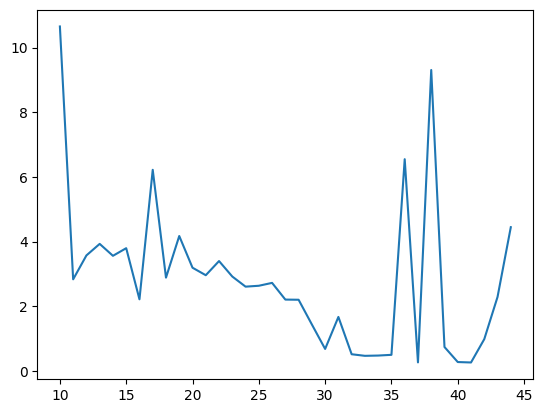

In [248]:
best_ind = Y_init.argmin()
best_x = X_init_norm[best_ind]
best_y = Y_init[best_ind]
best_x_unorm = unnormalize(best_x, bounds=bounds)

TRUSS1.state["monitor_df"]["Total Loss"][n_samples:].plot()

## <strong> 4 | Benchmarking against Karnachos </strong>

### <strong> 4.1 | Final Trusses & Basic statistics </strong>

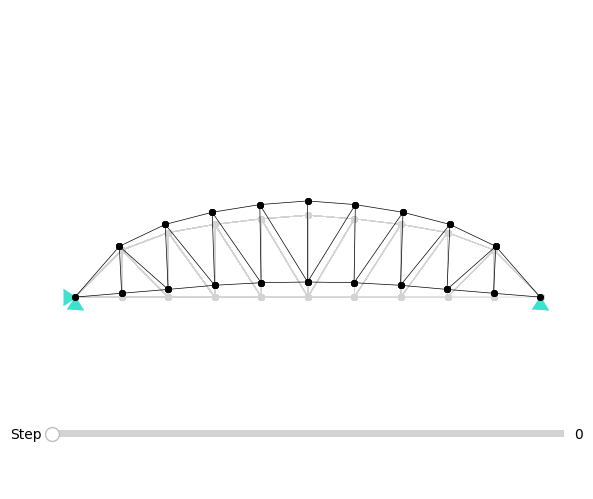

Smallest three natural frequencies:  [20.06682059 40.53905183 61.8225322 ]  Hz


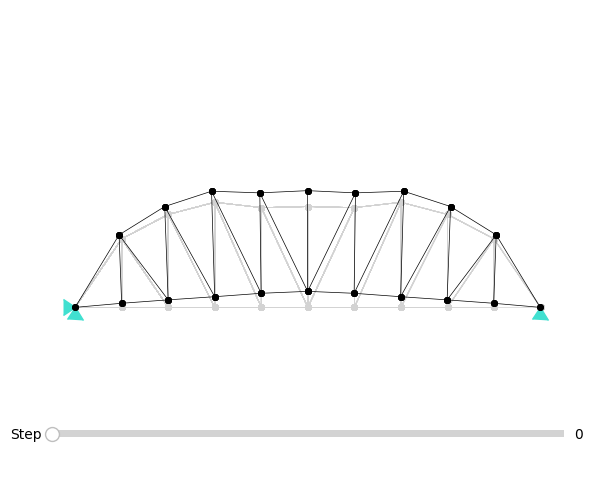

360.07710670521664

In [249]:
#                      IMPORT AND INTIATE KANARCHOS BRIDGE                     #
# ---------------------------------------------------------------------------- #
path_pro = os.path.normpath(os.path.join(read_file_path, 'bridge_frequency_kr.pro'))
props = pu.parse_file(path_pro)

path_geom = os.path.normpath(os.path.join(read_file_path, 'bridge_kanarachos.geom'))
props['model']['truss']['area'] = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
props['init']['mesh']['file'] = path_geom

trap = io.StringIO()
with redirect_stdout(trap):
    globdat = main.jive(props)
print('Smallest three natural frequencies: ', globdat[gn.EIGENFREQS][0:3]/2/np.pi, ' Hz')

final_results(write_file_path, TRUSS1, best_x_unorm , TRUSS1.state["cross_sections"])
# ------------------------ Initiate a Karnachos obect ------------------------ #
read_file_path = '../truss_bridge/data'
read_file = 'bridge_kanarachos.geom'
write_file_path =  None
write_file = None
violation_factor = None
freq_constraints = None
mass_weight = None
freq_weight = None
scalers = [None,None]
bounds = None

TRUSSKN= TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSSKN.read_geom_file()

y_coord = TRUSSKN.state["y_coordinates"][::2][1:6]
areas_kn = np.array(props['model']['truss']['area'])
TRUSSKN.mass_truss(areas_kn, y_coord)

In [250]:
# ----------------------------------- Data ----------------------------------- #
TR_cs = TRUSS1.state["cross_sections"].numpy()
KN_cs = TRUSSKN.state["cross_sections"]

TR_m = TRUSS1.mass_truss(TR_cs, TRUSS1.state["y_coordinates"][::2][1:6])
KN_m = TRUSSKN.mass_truss(KN_cs, TRUSSKN.state["y_coordinates"][::2][1:6])

NFK = globdat[gn.EIGENFREQS][0:3]/2/np.pi
NFTR = TRUSS1.state["monitor_df"]["Natural Frequencies"][best_ind.numpy()]

data = {
    'Model': ['Kanarachos model', 'TRUSS model'],
    'Cross Section Average': [KN_cs.mean(), TR_cs.mean()],
    'Natural Frequency Average': [np.mean(NFTR), np.mean(NFK)],
    'Mass': [KN_m, TR_m]
}
basic_comp = pd.DataFrame(data)
basic_comp.set_index('Model', inplace=True)
basic_comp.index.name = None
basic_comp

,Cross Section Average,Natural Frequency Average,Mass
Kanarachos model,0.000424,41.497568,360.077107
TRUSS model,0.000433,40.809468,371.645154


### <strong> 4.2 | Comparing benchmarks </strong>

In [251]:
max_cross_sections = max(np.max(TR_cs), np.max(KN_cs))
normalized_cross_sections_model1 = TR_cs / max_cross_sections
normalized_cross_sections_model2 = KN_cs / max_cross_sections

max_mass = max(TR_m, KN_m)
normalized_mass_model1 = TR_m / max_mass
normalized_mass_model2 = KN_m / max_mass

max_nat_freq = max(np.max(NFTR), np.max(NFK))
normalized_nat_freq_model1 = np.array(NFTR) / max_nat_freq
normalized_nat_freq_model2 = np.array(NFK) / max_nat_freq
# ------------------------------------ VIS ----------------------------------- #
data = {
    "Metric": ["Cross Sections (Mean)", "Mass", "Nat. Freq. 1", "Nat. Freq. 2", "Nat. Freq. 3"],
    "Model 1 (TRUSS1)": [np.mean(normalized_cross_sections_model1), normalized_mass_model1] + normalized_nat_freq_model1.tolist(),
    "Model 2 (TRUSSKN)": [np.mean(normalized_cross_sections_model2), normalized_mass_model2] + normalized_nat_freq_model2.tolist()
}
df = pd.DataFrame(data)

# Create a grouped bar chart for normalized cross sections, mass, and natural frequencies using plotly
barplot = px.bar(
    df,
    x='Metric',
    y=["Model 1 (TRUSS1)", "Model 2 (TRUSSKN)"],
    barmode='group',
    title='Comparison of Normalized Cross Sections, Mass, and Natural Frequencies',
    labels={'Metric': 'Metric', 'value': 'Normalized Value', 'variable': 'Model'},
    color_discrete_sequence=px.colors.qualitative.Set2  # Soft color palette
)
barplot.show()

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

